In [1]:
import os
os.chdir("..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from engine.cd import draw_cd_diagram

sns.set_theme()

IMPLEMENTED_MODELS = ["SGD", "IWLS", "ADAM"]

In [3]:
convergence = pd.read_csv("results/convergence_results.csv")

In [4]:
results = pd.read_csv("results/results.csv")

results.data.drop_duplicates()
results["is_big"] = results.data.isin(
    ["credit-g", "heart-statlog", "ionosphere", "kr-vs-kp", "sonar", "white-clover"]
).astype(int)
results["interaction"] = results.data.str.contains("iteractions").astype(int)
results["dataset"] = results.data.str.replace("-iteractions", "")

# CD plots for models

/home/dawid/miniconda3/envs/aml/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


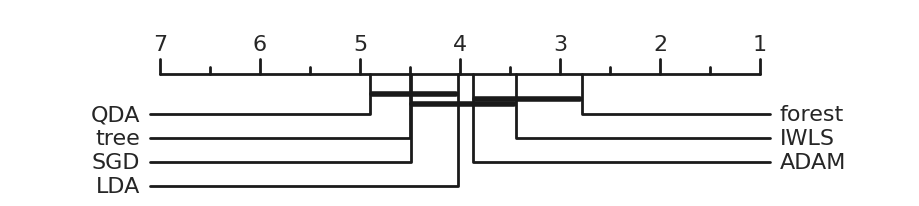

In [5]:
data_to_plot = (
    results[["model", "dataset", "score"]][(results.interaction == 0)]
    .rename(
        columns={
            "model": "classifier_name",
            "dataset": "dataset_name",
            "score": "accuracy",
        }
    )
    .assign(dataset_name=results.dataset + results.fold.astype(str))
    .reset_index(drop=True)
)
draw_cd_diagram(data_to_plot)

# Comparison interaction and non-interaction models

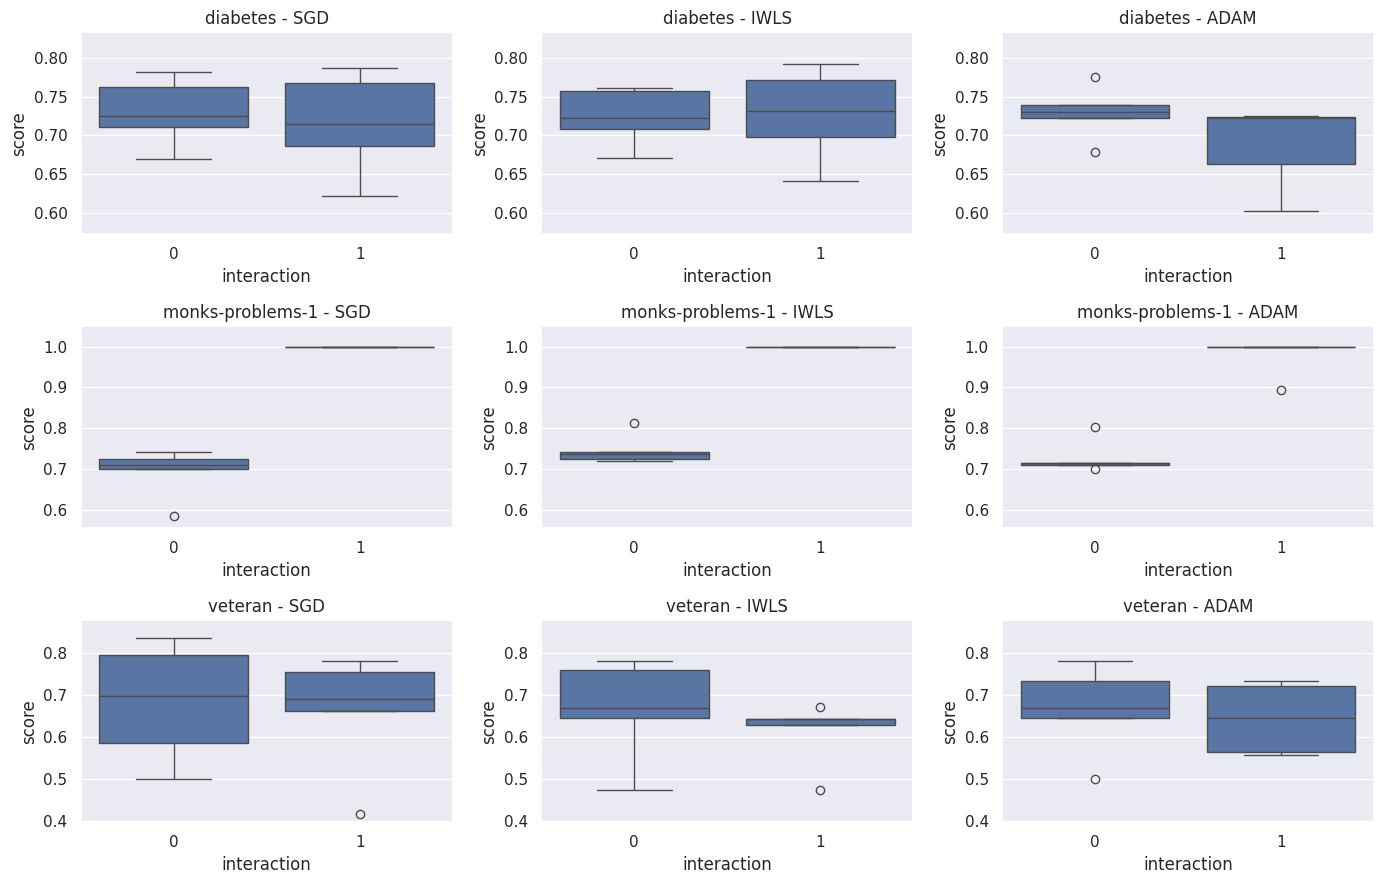

In [6]:
data_for_plot = results[results.is_big == 0]
datasets = list(sorted(data_for_plot.dataset.drop_duplicates().tolist()))

fig, ax = plt.subplots(nrows = len(datasets), ncols=len(IMPLEMENTED_MODELS), figsize=(14, 9))
for i, dataset in enumerate(datasets):
    aggregates = data_for_plot[
        data_for_plot.dataset == dataset
    ].score.describe()
    score_plot_min = max(aggregates["min"]*0.95, 0)
    score_plot_max = min(aggregates["max"]*1.05, 1.05)
    for j, model in enumerate(IMPLEMENTED_MODELS):
        plot = sns.boxplot(data=data_for_plot[
            (data_for_plot.model == model) 
            & (data_for_plot.dataset == dataset)
        ], x="interaction", y="score", ax=ax[i][j])
        plot.set_title(f"{dataset} - {model}")
        plot.set_ylim(score_plot_min, score_plot_max)
fig.tight_layout()

# Boxplots of performance per model

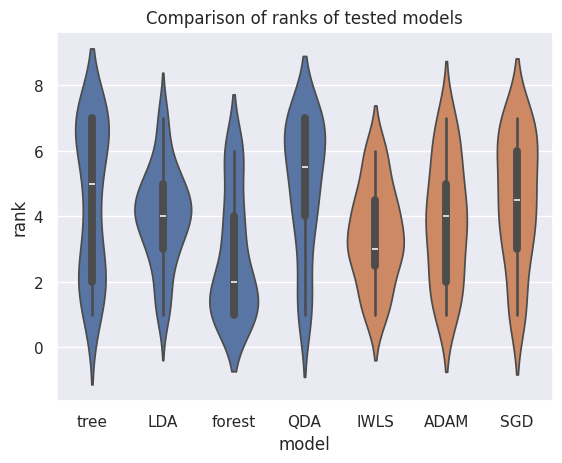

In [7]:
data_for_plot = (
    results[results.interaction == 0]
    .sort_values(["dataset", "model", "fold", "score"], ascending=False)
    .reset_index(drop=True)
)
ranks = data_for_plot.groupby(["dataset", "fold"]).rank(
    method="average", ascending=False
)
data_for_plot["rank"] = ranks["score"]
data_for_plot["is_implemented"] = data_for_plot.model.isin(IMPLEMENTED_MODELS)
data_for_plot = data_for_plot.sort_values("is_implemented")

plot = sns.violinplot(data=data_for_plot, x="model", y="rank", hue="is_implemented")
plot.set_title("Comparison of ranks of tested models")
plot.legend([], [], frameon=False)

# Covergence in loglik terms

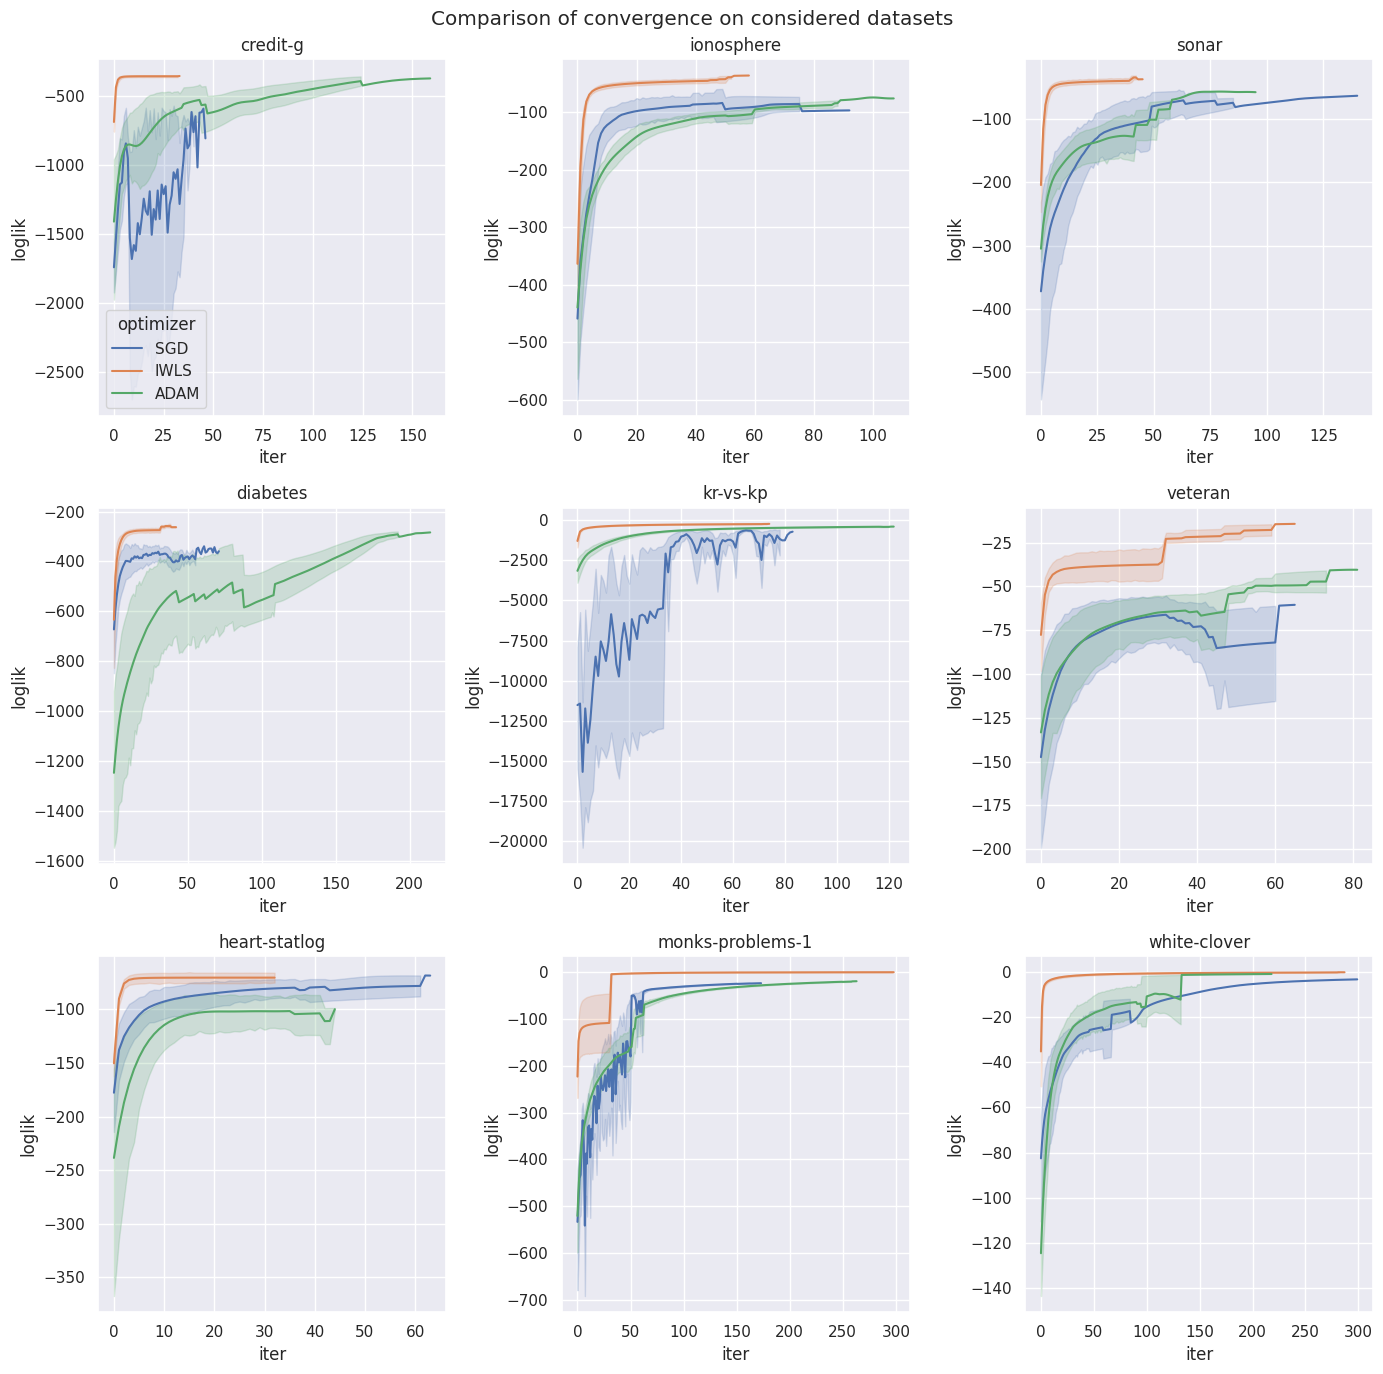

In [8]:
datasets = list(sorted(convergence.data.drop_duplicates().tolist()))
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(14, 14))
data_to_plot = convergence.assign(
    log_loglik=np.log(-convergence.loglik)
)

for i, dataset in enumerate(datasets):
    plot = sns.lineplot(
        data=data_to_plot[data_to_plot.data == dataset],
        x="iter",
        y="loglik",
        hue="optimizer",
        ax=ax[i % 3][i // 3],
    )
    if i != 0:
        plot.legend([], [], frameon=False)
    plot.set_title(dataset)

fig.suptitle("Comparison of convergence on considered datasets")
fig.tight_layout()